Loading sequences...

Finding closest breed...
Closest breed: gb|AY656744.1| [location=mitochondrion] [completeness=complete] [topology=circular] [organism=Canis lupus familiaris] [isolate=1] [sub_species=familiaris] [breed=English Springer Spaniel] [gcode=2] Canis lupus familiaris isolate 1 breed English Springer Spaniel mitochondrion, complete genome.
Similarity: 99.86%

Calculating p-value...
P-value: 0.009

Building phylogenetic tree...


<Figure size 2800x1680 with 0 Axes>

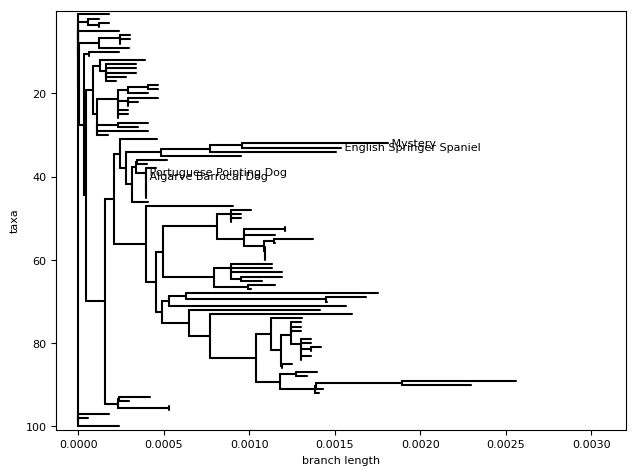

In [8]:
# ---------------- IMPORTS ----------------
import random
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
from Bio import Phylo
import matplotlib.pyplot as plt


# ---------------- I/O FUNCTIONS ----------------
def read_fasta(filepath):
    """
    Reads a FASTA file and returns a dictionary
    with header as key and sequence as value.
    """
    sequences = {}

    with open(filepath) as f:
        name = None
        seq = []

        for line in f:
            line = line.strip()

            if line.startswith(">"):
                if name:
                    sequences[name] = "".join(seq)
                name = line[1:]
                seq = []
            else:
                seq.append(line)

        if name:
            sequences[name] = "".join(seq)

    return sequences


# ---------------- SEQUENCE ANALYSIS ----------------
def percent_identity(seq1, seq2):
    """
    Calculates percentage identity between two sequences.
    Assumes sequences are same length.
    """
    matches = 0

    for i in range(len(seq1)):
        if seq1[i] == seq2[i]:
            matches += 1

    return (matches / len(seq1)) * 100


def percent_difference(seq1, seq2):
    """
    Returns percent difference between sequences.
    """
    return 100 - percent_identity(seq1, seq2)


def find_closest(mystery_seq, database):
    """
    Finds closest breed match.
    Returns breed name and similarity.
    """
    best_breed = None
    best_score = -1

    for breed, seq in database.items():
        score = percent_identity(mystery_seq, seq)

        if score > best_score:
            best_score = score
            best_breed = breed

    return best_breed, best_score


# ---------------- STATISTICS ----------------
def p_value(mystery_seq, best_seq, database, n=1000):
    """
    Calculates p-value using random sampling.
    """
    observed = percent_identity(mystery_seq, best_seq)

    count = 0
    db_seqs = list(database.values())

    for _ in range(n):
        rand_seq = random.choice(db_seqs)
        score = percent_identity(mystery_seq, rand_seq)

        if score >= observed:
            count += 1

    return count / n


# ---------------- PHYLOGENY ----------------
def build_distance_matrix(sequences):
    """
    Builds a distance matrix for phylogeny.
    """
    names = list(sequences.keys())
    matrix = []

    for i, name1 in enumerate(names):
        row = []
        for j in range(i + 1):
            name2 = names[j]
            dist = percent_difference(
                sequences[name1], sequences[name2]
            ) / 100
            row.append(dist)
        matrix.append(row)

    return DistanceMatrix(names, matrix)


def build_tree(distance_matrix):
    """
    Constructs Neighbor Joining tree.
    """
    constructor = DistanceTreeConstructor()
    return constructor.nj(distance_matrix)


def plot_tree(tree):
    """
    Displays phylogenetic tree.
    """
    def parsed_label(name):
        if name is None:
            return ""
        if name == "Mystery":
            return "Mystery"
        if "[breed=" in name:
            return name.split("[breed=", 1)[1].split("]", 1)[0]
        if name.startswith("gb|"):
            parts = name.split("|")
            if len(parts) > 1:
                return parts[1]
        return name if len(name) <= 30 else name[:27] + "..."

    terminals = tree.get_terminals()
    mystery = next((clade for clade in terminals if clade.name == "Mystery"), None)

    clade_names_to_show = {"Mystery"}
    if mystery is not None:
        nearest = sorted(
            (clade for clade in terminals if clade is not mystery),
            key=lambda clade: tree.distance(mystery, clade)
        )[:3]
        clade_names_to_show.update(clade.name for clade in nearest)

    def short_label(clade):
        if clade is None or clade.name is None:
            return ""

        if clade.name not in clade_names_to_show:
            return ""

        return parsed_label(clade.name)

    plt.figure(figsize=(20, 12), dpi=140)
    plt.rcParams["font.size"] = 8
    Phylo.draw(tree, label_func=short_label, do_show=False)
    plt.tight_layout()
    plt.show()


# ---------------- MAIN PROGRAM ----------------
if __name__ == "__main__":

    print("Loading sequences...")

    database = read_fasta("data/dog_breeds.fa")
    mystery = read_fasta("data/mystery.fa")

    mystery_seq = list(mystery.values())[0]

    # ---- Closest match ----
    print("\nFinding closest breed...")
    breed, similarity = find_closest(mystery_seq, database)

    print("Closest breed:", breed)
    print("Similarity: {:.2f}%".format(similarity))

    # ---- P-value ----
    print("\nCalculating p-value...")
    p = p_value(mystery_seq, database[breed], database)

    print("P-value:", p)

    # ---- Phylogeny ----
    print("\nBuilding phylogenetic tree...")
    database["Mystery"] = mystery_seq

    dm = build_distance_matrix(database)
    tree = build_tree(dm)

    plot_tree(tree)
